# Preparation

## Modules

In [5]:
import sys
import os
import warnings
import pickle

import numpy as np
import xarray as xr
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib
import cartopy
import cartopy.crs as ccrs
import pop_tools
import cmocean
import gsw
from mpl_toolkits.axes_grid1 import ImageGrid
import cftime
sys.path.insert(0, "/home/dpfluger/scripts/cesm_tools/")
import cesm_data_tools
import pop_plot
import cesm_scenarios
import geo_tools
import msf_tools
import colorcet

plt.style.use('seaborn')
matplotlib.rcParams['font.family'] = 'Nimbus Roman'
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2
# reset to standard notebook plotting after enabling animated plots
%matplotlib inline 

## Simulation data

In [6]:
cases_cnt = {'b.e21.BSSP585cmip6.f09_g17.control.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.01',
                                                        'years': np.arange(2015,2100)
                                                       }}
cases_sai20 = {'b.e21.BSSP585cmip6.f09_g17.2020feedback.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01','years': np.arange(2020,2045)},
               'b.e21.BSSP585cmip6.f09_g17.2020feedback.02': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02','years': np.arange(2045,2100)} }

cases_sai80 = {'b.e21.BSSP585cmip6.f09_g17.feedback.05': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.05',
                                                        'years': np.arange(2080,2086)},
               'b.e21.BSSP585cmip6.f09_g17.feedback.06': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.06',
                                                        'years': np.arange(2086,2100)}
}

cases_sai80j = {'b.e21.BSSP585cmip6.f09_g17.feedback.09': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09',
                                                        'years': np.arange(2080,2100)},
}

cases = [cases_cnt, cases_sai20, cases_sai80, cases_sai80j]

scenario_names = ['Control', 'SAI 2020', 'SAI 2080', 'SAI 2080 J']

scenarios = {name: cesm_scenarios.Scenario(name,case) for name, case in zip(scenario_names,cases)}

In [7]:
get_ocn_vars = ['SALT', 'TEMP', 'RHO', 
                'SHF', 'HMXL',
                'EVAP_F', 'PREC_F', 'SALT_F', 'SFWF', 'ROFF_F', 'MELT_F', 'MOC', 'N_HEAT']


get_ice_vars = ['fresh', 'fsalt']

get_atm_vars = ['TREFHT', 'FSNT', 'FLNT']

for var in get_ocn_vars:
    for name in scenarios:
        scenarios[name].get_ocn_var(var)

for var in get_ice_vars:
    for name in scenarios:
        scenarios[name].get_ice_var(var)

for var in get_atm_vars:
    for name in scenarios:
        scenarios[name].get_atm_var(var)

## CMIP6 data

In [8]:
# load data
ssp_labels = ['ssp126','ssp245','ssp370','ssp585']
amoc_cmip = {}

cmip_data_path = '/home/dpfluger/analysis/amoc'

for name in ssp_labels:

    da_1 = xr.concat([xr.open_dataset(f'{cmip_data_path}/cmip6/msftmz_Omon_CESM2_{name}_r4i1p1f1_gn_201501-206412.nc'),
        xr.open_dataset(f'{cmip_data_path}/cmip6/msftmz_Omon_CESM2_{name}_r4i1p1f1_gn_206501-210012.nc')],dim='time')
    da_2 = xr.concat([xr.open_dataset(f'{cmip_data_path}/cmip6/msftmz_Omon_CESM2_{name}_r10i1p1f1_gn_201501-206412.nc'),
        xr.open_dataset(f'{cmip_data_path}/cmip6/msftmz_Omon_CESM2_{name}_r10i1p1f1_gn_206501-210012.nc')],dim='time')
    da_3 = xr.concat([xr.open_dataset(f'{cmip_data_path}/cmip6/msftmz_Omon_CESM2_{name}_r11i1p1f1_gn_201501-206412.nc'),
        xr.open_dataset(f'{cmip_data_path}/cmip6/msftmz_Omon_CESM2_{name}_r11i1p1f1_gn_206501-210012.nc')],dim='time')
    
    amoc_cmip[name] = xr.concat([da_1.msftmz,da_2.msftmz,da_3.msftmz],pd.Index([0,1,2],name='ens'))

## Utilities

In [14]:
pop_ds = xr.open_dataset('/home/dpfluger/links/leo_archive/b.e21.BSSP585cmip6.f09_g17.control.01/ocn/hist/b.e21.BSSP585cmip6.f09_g17.control.01.pop.h.2021-01.nc')
tarea_global = pop_ds.TAREA * 10**(-4)
dz = pop_ds.dz * 10**(-2)

def ocean_heat_content(da,tarea=tarea,dz=dz):
    
    '''
    To-Do: check z integration: what scheme does xarray use? do we have the right spatial coordinate?
    note that z is the distance from surface to the _mid_layer depth
    
    units of tarea: m^2 and dz: m
    '''
    
    rho = 1025 # kg m^-3
    C = 3985 # J kg^-1 K^-1
    
    phi = rho * C * (tarea * (dz * da).sum(dim='z_t')).sum(['nlat','nlon']) 
    
    return phi

def ocean_heat_map(da,dz=dz):
    
    '''
    Compute OHC anomaly in every grid cell separately
    This means that the nlat,nlon summation step is not performed in comparison with ocean_heat_content
    
    Output in units J / m^2 (ocean heat stored in a water column)
    '''
    
    rho = 1025 # kg m^-3
    C = 3985 # J kg^-1 K^-1
    
    phi = rho * C * ((dz * da).sum(dim='z_t'))
    
    return phi

def ocean_heat_layers(da,tarea=tarea,dz=dz):
    '''
    Compute OHC anomaly in every separate layer
    This means that the z summation is not carried out
    
    Output in units J (ocean heat stored in given layer)
    '''
    
    rho = 1025 # kg m^-3
    C = 3985 # J kg^-1 K^-1
    
    phi = rho * C * (dz * (da*tarea).sum(dim=['nlat','nlon']))
    
    return phi

def max_ohc_depth_map(da,
                      tarea=tarea,
                      dz=dz,
                      ts_ref=slice('2020','2029'),
                      ts_test=slice('2090','2099')):
    '''
    Map out at which level at every grid point there is a maximum increase in OHC. E.g., a value of
    1000m at a fixed location would mean that the maximum change in OHC happens at that particular depth.
    '''
    
    
    # 3D heat content computation
    # Note that taking an average over time helps avoid too strong noise
    # Multiplication with grid cell sizes is saved for later
    # Note that taking the maximum is independent of the positive scaling factor rho * c
    # It can therefore be omitted entirely
    phi_ref  = da.sel(time=ts_ref).mean(dim='time')
    phi_test = da.sel(time=ts_test).mean(dim='time')
    
    phi_diff = (phi_test - phi_ref) * dz * tarea
    phi_diff = phi_diff.fillna(0) # Avoid all-NaN values (in land regions)
    depth_of_max_diff = phi_diff.idxmax(dim='z_t') # returns the z-_position_ of the maximum 
    
    return depth_of_max_diff

def rm(da,roll_window = 12):
    '''
    Rolling mean
    '''
    return da.rolling(time=roll_window).mean()

def moc_max(da,lat=26,min_depth=None,comps=slice(None,None)):
    '''
    Evaluate AMOC maximum at fixed latitude (in deg N) below certain depth (in m)
    
    Note: sum over MOC components (advective & eddies): this is the format of the CMIP6 variables
    '''
    if min_depth:
        min_depth = min_depth * 100 # unit conversion: m -> cm
        
    # select amoc
    da_amoc = da.isel(transport_reg=1)
    # select latitude and depth
    da_amoc = \
        da_amoc.sel(lat_aux_grid=lat,method='nearest') \
        .sel(moc_z=slice(min_depth,None))
    
    # sum over components
    da_amoc = da_amoc.sel(moc_comp=comps)
    da_amoc = da_amoc.sum(dim='moc_comp')

    return da_amoc.max(dim='moc_z')

def moc_max_lat_interval(da,lat=slice(0,90),min_depth=None,comps=slice(None,None)):
    '''
    Evaluate AMOC maximum over latitude interval below certain depth (in m)
    
    Note: sum over MOC components (advective & eddies): this is the format of the CMIP6 variables
    '''
    if min_depth:
        min_depth = min_depth * 100 # unit conversion: m -> cm
        
    # select amoc
    da_amoc = da.isel(transport_reg=1)
    # select latitude and depth
    da_amoc = \
        da_amoc.sel(lat_aux_grid=lat) \
        .sel(moc_z=slice(min_depth,None))
    
    # sum over components
    da_amoc = da_amoc.sel(moc_comp=comps)
    da_amoc = da_amoc.sum(dim='moc_comp')

    return da_amoc.max(dim=['moc_z','lat_aux_grid'])


def moc_argmax_lat_interval(da,lat=slice(0,90),min_depth=None,comps=slice(None,None)):
    '''
    Evaluate AMOC maximum over latitude interval below certain depth (in m)
    
    Note: sum over MOC components (advective & eddies): this is the format of the CMIP6 variables
    '''
    if min_depth:
        min_depth = min_depth * 100 # unit conversion: m -> cm
        
    # select amoc
    da_amoc = da.isel(transport_reg=1)
    # select latitude and depth
    da_amoc = \
        da_amoc.sel(lat_aux_grid=lat) \
        .sel(moc_z=slice(min_depth,None))
    
    # sum over components
    da_amoc = da_amoc.sel(moc_comp=comps)
    da_amoc = da_amoc.sum(dim='moc_comp')

    return da_amoc.argmax(dim=['moc_z','lat_aux_grid'])

def mht_max(da,lat=slice(0,None)):
    '''
    Evaluate maximum MHT for AMOC in given latitude range (default is northern hemisphere)
    '''
    da_amoc = da.isel(transport_reg=1,transport_comp=1)
    da_amoc = da_amoc.sel(lat_aux_grid=lat)
    return da_amoc.max(dim='lat_aux_grid')

def mht_argmax(da,lat=slice(0,None)):
    '''
    Evaluate maximum MHT for AMOC in given latitude range (default is northern hemisphere)
    '''
    da_amoc = da.isel(transport_reg=1,transport_comp=1)
    da_amoc = da_amoc.sel(lat_aux_grid=lat)
    return da_amoc.argmax(dim='lat_aux_grid')

def mht(da,lat=26):
    '''
    Evaluate MHT for AMOC at fixed latitude (in deg N)
    '''
    da_amoc = da.isel(transport_reg=1,transport_comp=1)
    da_amoc = da_amoc.sel(lat_aux_grid=lat,method='nearest')
    return da_amoc

def moc_max_cmip(da,lat=26,min_depth=None,rho_ref=1030):
    '''
    Evaluate AMOC maximum for mean velocity field stream function
    at fixed latitude (in deg N) below certain depth (in m) (using CMIP6 data)
    '''
    if min_depth:
        min_depth = min_depth * 100 # unit conversion: m -> cm
        
    # select amoc
    da_amoc = da.isel(basin=0)
        
    # convert to volumetric AMOC rather mass AMOC
    # units of sv
    da_amoc = da_amoc/(rho_ref * 10**6)
    
    # select latitude and depth
    da_amoc = \
        da_amoc.sel(lat=lat,method='nearest') \
        .sel(lev=slice(min_depth,None))

    return da_amoc.max(dim='lev')

def moc_max_lat_interval_cmip(da,lat=slice(0,90),min_depth=None,rho_ref=1030):
    '''
    Evaluate AMOC maximum for mean velocity field stream function
    at fixed latitude (in deg N) below certain depth (in m) (using CMIP6 data)
    '''
    if min_depth:
        min_depth = min_depth * 100 # unit conversion: m -> cm
        
    # select amoc
    da_amoc = da.isel(basin=0)
        
    # convert to volumetric AMOC rather mass AMOC
    # units of sv
    da_amoc = da_amoc/(rho_ref * 10**6)
    
    # select latitude and depth
    da_amoc = \
        da_amoc.sel(lat=lat) \
        .sel(lev=slice(min_depth,None))

    return da_amoc.max(dim=['lev','lat'])

def concat_sai2080(var_name,ts=slice('2070','2079'),sai80_name='SAI 2080'):
    da_concat = xr.concat([scenarios['Control'][var_name].sel(time=ts),
                           scenarios[sai80_name][var_name]],dim='time')
    return da_concat

for var in ['TREFHT','MOC','N_HEAT']:
    scenarios['SAI 2080'].var[var] = concat_sai2080(var)

## Masks

In [15]:
grid_name = 'POP_gx1v7'
pop_regions = pop_tools.get_grid(grid_name)

# Global mask
pop_ds = xr.open_dataset('/home/dpfluger/links/leo_archive/b.e21.BSSP585cmip6.f09_g17.control.01/ocn/hist/b.e21.BSSP585cmip6.f09_g17.control.01.pop.h.2021-01.nc')
tarea_global = pop_ds.TAREA * 10**(-4)
tarea_global = tarea_global.where((pop_regions.REGION_MASK != 0)).fillna(0)
dz = pop_ds.dz * 10**(-2)

# Atlantic/Arctic sea regions
# 'Atlantic Ocean', 'Lab. Sea & Baffin Bay', 
# 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'
#region_ids = [7,9,10,11,12]
region_ids = [7, 9]
pop_regions.region_name.isel(nreg=region_ids)
region_vals = pop_regions.region_val.sel(nreg=region_ids)

# select Atlantic and Polar seas
ones = xr.ones_like(pop_regions.REGION_MASK)
mask = xr.zeros_like(pop_regions.REGION_MASK)
for r_id in region_vals:
    mask_partial = ones.where(pop_regions.REGION_MASK==r_id)
    mask_partial = mask_partial.fillna(0)
    mask = mask + mask_partial
# Focus on Northern Atlantic
mask = mask.where((pop_regions.TLAT>45) & (pop_regions.TLAT<65) & (pop_regions.TLONG>280)).fillna(0)

tarea_mask_na = tarea_global * mask

In [16]:
# Use APRIL as reference month
month_i = 4 # April: 4th month
mx_month = scenarios['Control'].var['HMXL'].sel(time=slice('2015','2030')).groupby('time.month')[month_i]
mx_month = mx_month.mean(dim='time')

cut_off_depth = 55000
dwf_regions = (mx_month>cut_off_depth).compute() # GLOBAL!
tarea_dwf = tarea_mask_na.where(dwf_regions>0).fillna(0).compute() # Narrow selection down to North Atlantic

dwf_west = dwf_regions.where(dwf_regions.TLONG<318).fillna(0)
dwf_east = dwf_regions.where(dwf_regions.TLONG>320).fillna(0) # this cuts of an overlapping point

tarea_dwf_west = tarea_dwf.where(dwf_west>0).fillna(0)
tarea_dwf_east = tarea_dwf.where(dwf_east>0).fillna(0)

# redefine tarea_dwf such that the overlapping point is omitted
tarea_dwf = tarea_dwf_west + tarea_dwf_east
dwf_regions = dwf_west + dwf_east

## Utilities 2

In [17]:

def thermal_sdf(scenario):
    '''
    Thermal contribution to thermal surface density flux
    
    Parameters:
    shf (xr.DataArray): surface heat flux
    '''
    
    sst = scenario.var['TEMP'].isel(z_t=0)
    sss = scenario.var['SALT'].isel(z_t=0) 
    shf = scenario.var['SHF']
    
    cp = gsw.cp_t_exact(sss,sst,0)
    alpha = gsw.alpha_wrt_t_exact(sss,sst,0)
    
    tsdf = - alpha * shf/cp
    
    return tsdf

def haline_sdf(scenario):
    '''
    Thermal contribution to thermal surface density flux
    
    Parameters:
    scenario (Scenario)
    '''
    
    sss = scenario.var['SALT'].isel(z_t=0) # sea surface salinity, g/kg
    sst = scenario.var['TEMP'].isel(z_t=0) # surface pot temp, deg C
    #rho_fresh = gsw.rho_t_exact(0,sst,0) # density of sea surface assuming no salinity 
    
    beta = gsw.beta_const_t_exact(sss,sst,0)
    
    # Freshwater flux
    #evap = scenario.var['EVAP_F'] # negative values
    #prec = scenario.var['PREC_F'] # positive values
    
    sfwf = scenario.var['SFWF'] # N Howe et al, 2009, J Phys Ocean
    
    # Haline SDF
    # hsdf = - rho_fresh * beta * (sfwf * sss)/(1-sss)
    #hsdf = - beta * (sfwf * sss)/(1-sss)
    hsdf = - beta * sfwf * sss
    
    return hsdf

def atm_fw(scenario):
    '''
    Compute atmospheric freshwater flux (precipitation - evaporation)
    Positive values: freshwater flux into ocean
    '''
    # Freshwater flux
    evap = scenario.var['EVAP_F'] # negative values
    prec = scenario.var['PREC_F'] # positive values
    
    # 
    sfwf = prec + evap
    
    return sfwf

def ice_fw(scenario):
    
    # Ice
    sss = scenario.var['SALT'].isel(z_t=0)
    rho = scenario.var['RHO'].isel(z_t=0)
    salt_f = scenario.var['SALT_F']
    
    ice_term = salt_f * sss * rho
    
    return ice_term

def atm_ice_fw(scenario):
    '''
    Compute freshwater flux including ice contribution
    '''
    atm_term = atm_fw(scenario) 
    ice_term = ice_fw(scenario)
    
    total_fw = atm_term + ice_term
    
    return total_fw 
    
def march_ml_depth(scenario):
    
    ml_march = scenario.var['HMXL'].groupby('time.month')[3]
    
    return ml_march

def max_march_ml_depth(scenario):
    
    ml_march = march_ml_depth(scenario)
    max_ml_march = ml_march.max(dim=['nlat','nlon'])
    
    return max_ml_march

def month_ml_depth(scenario,month_i=month_i):
    
    ml_month = scenario.var['HMXL'].groupby('time.month')[month_i]
    return ml_month

def max_month_ml_depth(scenario,month_i=month_i):
    
    ml_month = month_ml_depth(scenario,month_i)
    max_ml_month = ml_month.max(dim=['nlat','nlon'])
    
    return max_ml_month
    
def get_sst(scenario):
    
    sst = scenario.var['TEMP'].isel(z_t=0)
    
    return sst

def get_sss(scenario):
    
    sss = scenario.var['SALT'].isel(z_t=0)
    
    return sss

# Means, plotting etc.

def global_ocn_mean(scenario,func,mask=tarea_global):
    
    weighted_sum = (func(scenario) * mask).sum(['nlat','nlon'])

def masked_ocn_mean(scenario,func,mask=tarea_mask_na):
    
    weighted_sum = (func(scenario) * mask).sum(['nlat','nlon'])
    norm = mask.sum(['nlat','nlon'])
    
    return weighted_sum/norm

def apply_on_scenarios(scenarios,func):
    
    result_dict = {}
    for name in scenarios:
        print(name)
        result_dict[name] = func(scenarios[name]).compute()
        
    return result_dict

def annual_mean_on_scenarios(in_dict):
    result_dict = {}
    for name in in_dict:
        result_dict[name] = in_dict[name].groupby('time.year').mean(dim='time').compute()
    return result_dict

def dwf_mean_z(da, mask_roi = tarea_dwf):
    if 'time' in da.dims:
        da_ss = da.isel(time=0) # 'snapshot' of input data (eliminates time dim)
    else:
        da_ss = da
    z_mask = xr.ones_like(da_ss).where(np.isfinite(da_ss)) * mask_roi
    
    weighted_sum = (da * z_mask).sum(dim=['nlat','nlon'])
    norm = z_mask.sum(dim=['nlat','nlon'])
    
    return weighted_sum/norm

def strat_index(scenario,**kwargs):
    '''
    Reference depth z_test in m
    Computes density difference between top and reference layer for region of interest
    '''
    return top_minus_ref(scenario['RHO'],**kwargs)

def top_minus_ref(da,z_test=200,mask_roi=tarea_dwf):
    '''
    This is much faster thanks to the pre-selection! -> ~ factor six performance increase
    '''
    
    # do preselection based on mask_roi
    bool_mask = tarea_dwf > 0
    da_sel = da.where(bool_mask,drop=True)
    mask_roi_sel = mask_roi.where(bool_mask,drop=True)
    
    two_layers = da_sel.sel(z_t=(0,z_test*100),method='nearest')
    diff = dwf_mean_z(two_layers.diff(dim='z_t'),mask_roi=mask_roi_sel)
    
    return diff.isel(z_t=0)


def dwf_mean(da,mask_roi=tarea_dwf):
    
    weighted_sum = (da * mask_roi).sum(dim=['nlat','nlon'])
    norm = mask_roi.sum()
    
    return weighted_sum/norm

def dwf_int(da,mask_roi=tarea_dwf):
    '''
    units:
    [mask_area] m^2
    [output]: da * m^2 
    
    '''

    weighted_sum = (da * mask_roi).sum(dim=['nlat','nlon'])
    
    return weighted_sum

def dwf_max(da,bin_mask_roi=dwf_regions):
    
    masked_da = da * bin_mask_roi
    return masked_da.max(dim=['nlat','nlon'])

def dwf_vol(da,mask_roi=tarea_dwf):
    
    ml_vol = (da * mask_roi).sum(dim=['nlat','nlon'])
    # when skipping the normalization step, we obtain a mixed layer volume
    # rather than an avg ml depth
    # mixed layer volume = sum of mixed layer depths * grid cell are over all grid cells
    
    return ml_vol

# 1 Global Time Series

Show for all three scenarios
* Time series of GMST
* Time series of global OHC (with integrated TOA imbalance)
* Vertical profile of OHC (change late - early century)

Layout
Time series GMST | Time series OHC | Vertical profile OHC

## Computation

In [18]:
'''
global_ocean_heat = {scenario: ocean_heat_content(scenarios[scenario].var['TEMP'],tarea).compute() for scenario in ['Control', 'SAI 2020', 'SAI 2080']}
layers = {name: ocean_heat_layers(scenarios[name].var['TEMP']).compute() for name in scenarios}
for name in scenarios:
    global_ocean_heat[name].to_netcdf(f'./data/{name}_ohc.nc')
    layers[name].to_netcdf(f'./data/{name}_layers.nc')
'''

"\nglobal_ocean_heat = {scenario: ocean_heat_content(scenarios[scenario].var['TEMP'],tarea).compute() for scenario in ['Control', 'SAI 2020', 'SAI 2080']}\nlayers = {name: ocean_heat_layers(scenarios[name].var['TEMP']).compute() for name in scenarios}\nfor name in scenarios:\n    global_ocean_heat[name].to_netcdf(f'./data/{name}_ohc.nc')\n    layers[name].to_netcdf(f'./data/{name}_layers.nc')\n"

In [19]:
gmst = {name: geo_tools.global_mean(scenarios[name].var['TREFHT']).groupby('time.year').mean(dim='time').compute() for name in scenarios}

global_ocean_heat = {
    name: xr.open_dataset(f'./data/{name}_ohc.nc').__xarray_dataarray_variable__ for name in scenarios
}

layers = {
    name: xr.open_dataset(f'./data/{name}_layers.nc').__xarray_dataarray_variable__ for name in scenarios
}

ohc_ref = global_ocean_heat['Control'].sel(time=slice('2020','2030')).mean()

In [20]:
ref_layers = layers['Control'].sel(time=slice('2020','2029')).mean(dim='time')
diff_layers = {
    name: (layers[name].sel(time=slice('2090','2099')).mean(dim='time') - ref_layers) for name in scenarios
}

diff_layers_dz = {
    name: (layers[name].sel(time=slice('2090','2099')).mean(dim='time') - ref_layers)/dz for name in scenarios
}

In [21]:
for name in diff_layers_dz:
    diff_layers_dz[name]['z_t'] = diff_layers_dz[name]['z_t']/100
    diff_layers[name]['z_t'] = diff_layers[name]['z_t']/100

In [22]:
surface_area = 5.1 * 10**14 
net_flux = 1 # net radiative flux, W / m^2
year = 365 * 24 * 3600 # length of year in seconds

e_scale = 10**22 # energy scale in Joule/ slight warming of entire ocean (~0.1K, 0.01K? which is it)

scenarios['SAI 2080'].var['FSNT'] = xr.concat(
    [scenarios['Control']['FSNT'].sel(time=slice(None,'2079')),
     scenarios['SAI 2080']['FSNT'].sel(time=slice('2080',None))],dim='time')
scenarios['SAI 2080'].var['FLNT'] = xr.concat(    
    [scenarios['Control']['FLNT'].sel(time=slice(None,'2079')),
     scenarios['SAI 2080']['FLNT'].sel(time=slice('2080',None))],dim='time')
# compute the radiative balance
for name in scenarios:
    scenarios[name].var['net_tom_flux'] = scenarios[name].var['FSNT'] - scenarios[name].var['FLNT']
    scenarios[name].var['net_tom_flux'].compute()
    
def integrate_rad_balance(net_tom_flux):
    da = net_tom_flux
    mean_flux = geo_tools.global_mean(da).groupby('time.year').mean(dim='time') # Spatial and annual mean
    
    surface_area = 5.1 * 10**14 # m^2
    dt = 365 * 24 * 3600 # seconds per year
    
    integral = mean_flux.cumsum(dim='year') # perform cumulative integration
    integral = integral * surface_area * dt # weighing by time step and earth surface area
    
    return integral

## Plot

In [23]:
fsize = 8
fsize_min = 6

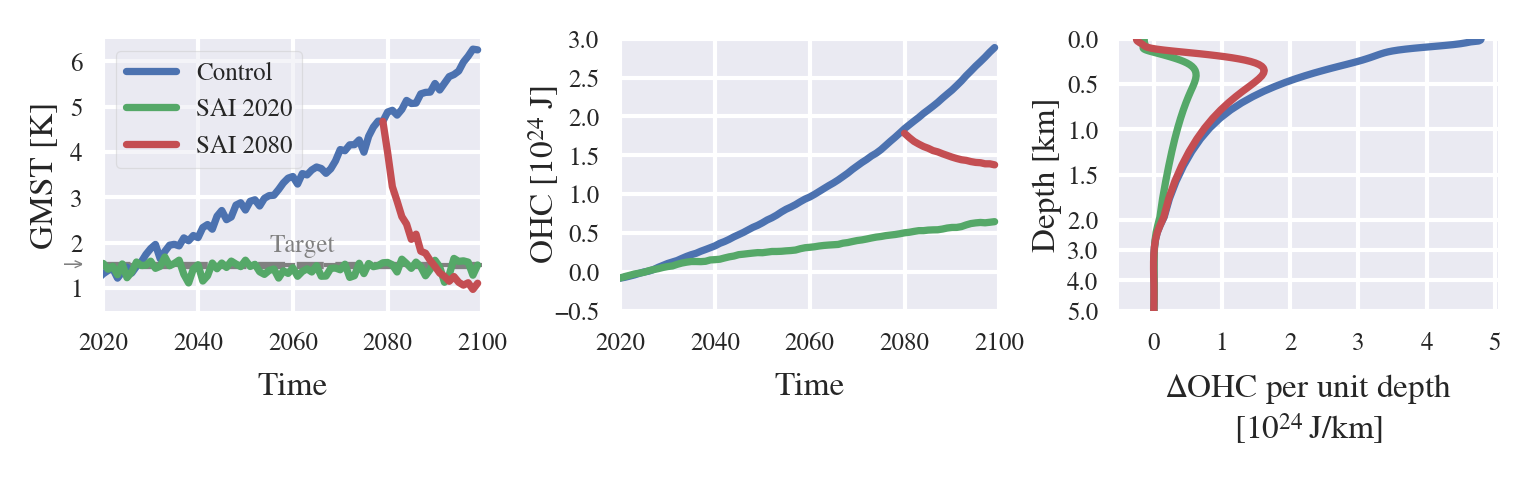

In [24]:
fig1, axes = plt.subplots(1, 3,figsize=(6,1.2),dpi=300,
                        gridspec_kw={'width_ratios':[1,1,1], 'wspace':0.34})

#fig.suptitle('Global')

T_ref = 288.73-1.5 
T_target = T_ref+1.5 

'''
# break axis of third plot
divider = make_axes_locatable(axes[2])
ax_div = divider.new_vertical(size="100%",pad=0.1)
fig.add_axes(ax_div)
'''
colors = ['C0','C1','C2']
for name,color in zip(['Control','SAI 2020', 'SAI 2080'],colors):
    if name=='SAI 2080':
        (gmst[name]-T_ref).sel(year=slice('2079','2100')).plot(ax=axes[0],label=name,zorder=2)
    else:
        (gmst[name]-T_ref).plot(ax=axes[0],label=name,zorder=2)
    ((global_ocean_heat[name].groupby('time.year').mean(dim='time')-ohc_ref)/1e24).plot(ax=axes[1],label=name)
    
    #(integrate_rad_balance(scenarios[name]['net_tom_flux'])/1e24).plot(ax=axes[1],color=color,linestyle='dashed')
    
    # vertical profile
    
    z_t = diff_layers_dz[name].z_t # units m
    diff_layer_unit = 1e21
    axes[2].plot(diff_layers_dz[name].data/(diff_layer_unit),z_t)
    #ax_div.plot(diff_layers_dz[name].data,z_t)

for ax in axes:
    ax.tick_params(axis='both',labelsize=fsize_min,pad=5)

# x axis formatting
for ax in [axes[0],axes[1]]:
    ax.set_xlabel('Time',fontsize=fsize)
    ax.set_xticks([2020,2040,2060,2080,2100])
    ax.set_xlim([2020,2100]) 

    
axes[0].axhline(y=1.5,color='grey',linestyle='dashed',zorder=1)
axes[0].text(2055, 1.8, 'Target',color='grey',fontsize=fsize_min)
axes[0].legend(fontsize=fsize_min,frameon=True,framealpha=0.5,edgecolor=None)
axes[0].set_ylabel('GMST [K]',fontsize=fsize,labelpad=1.2)

axes[0].set_yticks([0,1,1.5,2,3,4,5,6])
axes[0].set_yticklabels(["0","1","→","2","3","4","5","6"])
axes[0].get_yticklabels()[2].set_color('grey')
axes[0].get_ygridlines()[2].set_color('grey')
axes[0].get_ygridlines()[2].set_linestyle('dashed')

axes[0].set_ylim([0.5,6.5])

axes[1].set_ylabel(r'OHC [$\mathregular{10^{24}}$ J]',fontsize=fsize,labelpad=-2.0)
axes[1].set_ylim([-0.5,3.0])
axes[1].set_yticks([-0.5,0,0.5,1,1.5,2.0,2.5,3.0])


axes[2].set_xlabel(r'$\mathregular{\Delta}$OHC per unit depth'+'\n'+r'[$\mathregular{10^{24}}\,$J/km]',fontsize=fsize)
axes[2].set_ylabel('Depth [km]',fontsize=fsize,labelpad=1.2)

#axes[2].set_yticklabels([0,1,2,3,4,5],fontsize=fsize_min)
axes[2].set_ylim([0,5000])
axes[2].invert_yaxis()

axes[2].set_xticks([0,1,2,3,4,5])
axes[2].set_xticklabels([0,1,2,3,4,5])

'''
axes[2].invert_yaxis()
axes[2].set_yticklabels([4,4.5,5])

axes[2].set_ylim([4000,5000])

ax_div.set_xticks([0,1e21,2e21,3e21,4e21,5e21])
axes[2].set_xticks([0,1e21,2e21,3e21,4e21,5e21])

axes[2].set_xlim([0,5e21])
ax_div.set_xlim([0,5e21])
'''


dx = 0.005
pos = axes[1].get_position()
pos.x0 += dx     
pos.x1 += dx
axes[1].set_position(pos)


# Function Mercator transform
z_deep=2000
shrink_factor=3

def forward(z):
    if z<z_deep:
        return z
    else:
        return (z-z_deep)/shrink_factor+z_deep
forward = np.vectorize(forward,otypes=[np.float64])

def inverse(z_trans):
    if z_trans<z_deep:
        return z_trans
    else:
        return (z_trans-z_deep)*shrink_factor+z_deep
inverse = np.vectorize(inverse,otypes=[np.float64])

axes[2].set_yscale('function', functions=(forward, inverse))
axes[2].set_yticks([0,500,1000,1500,2000,3000,4000,5000])
axes[2].set_yticklabels(['0.0',0.5,1.0,1.5,2.0,3.0,4.0,5.0])

#fig.tight_layout(pad=0.15)

fig1.align_ylabels(axes)
fig1.align_xlabels(axes)

plt.show()

In [25]:
fig1.savefig('./gfx/fig_1.pdf',bbox_inches='tight')

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


# 2 Regional Distributions

Show temperature patterns for ref, changes in all scenarios & diffs between sai scenarios

2x2 square for ref and changes | diff between sai scenarios

## Computations

In [26]:
from cartopy.util import add_cyclic_point

In [27]:
ts_ref = slice('2020','2029')
ts_late = slice('2090','2099')
temp_map = {}
temp_map['Ref'] = scenarios['Control'].var['TREFHT'].sel(time=ts_ref).mean(dim='time').compute()
for name in scenarios:
    temp_late = scenarios[name].var['TREFHT'].sel(time=ts_late).mean(dim='time')
    temp_map[name] = (temp_late - temp_map['Ref']).compute()

temp_map['Diff'] = (temp_map['SAI 2080'] - temp_map['SAI 2020']).compute()

temp_map_new = {}
lon = temp_map['Ref'].lon
for name in temp_map:
    data_cyclic, lon_new = add_cyclic_point(temp_map[name].values, coord=lon)
    temp_map_new[name] = xr.DataArray(data=data_cyclic,dims=['lat','lon'],
                                      coords={'lon': lon_new, 'lat': temp_map['Ref'].lat}
                                    )
    
temp_map = temp_map_new

In [28]:
temp_map['Ref'].loc[:] = temp_map['Ref'].data - 273

## Plots

In [29]:
fsize = 8
fsize_min = 6

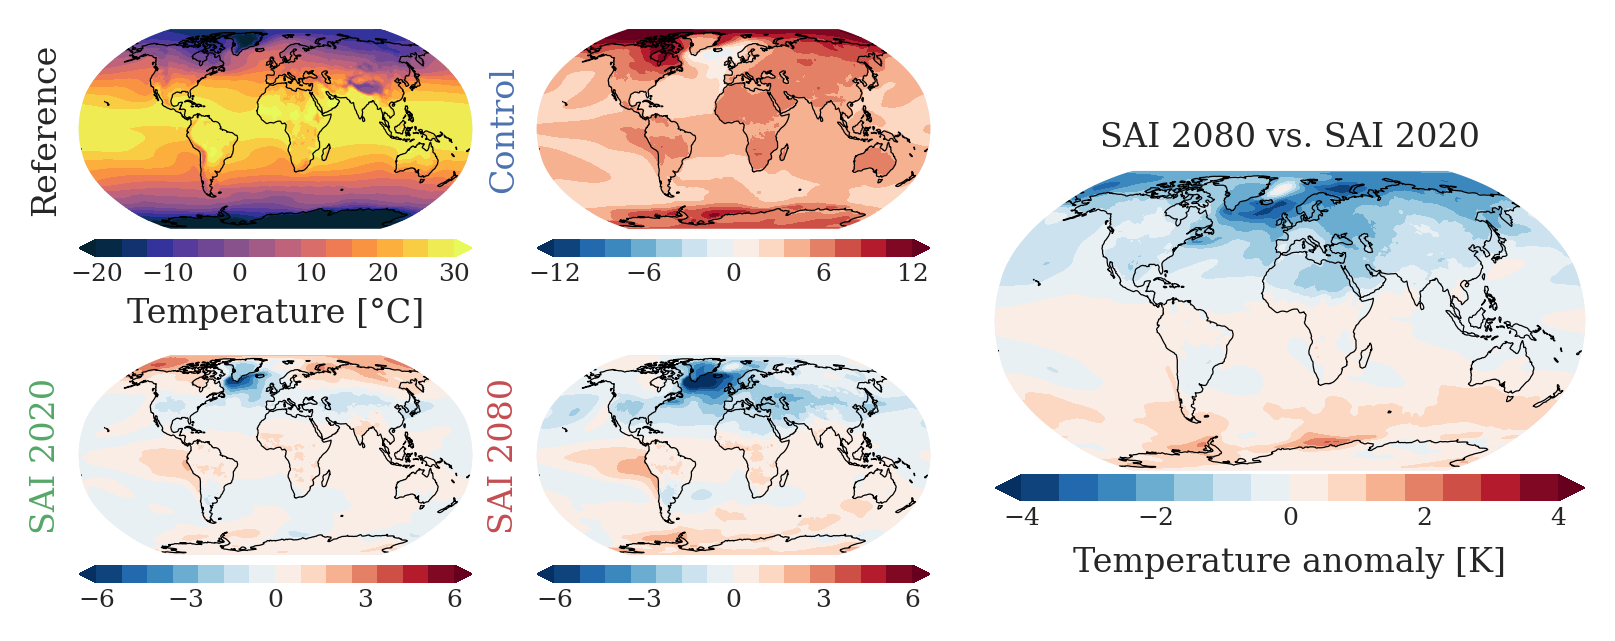

In [30]:
plt.rcParams["font.family"] = "serif"

#heights = [1.5,1]
widths = [1,1,1.5]
fig2, axs = plt.subplots(ncols=3, nrows=2, figsize=(7.2*0.9,3.6*0.9),dpi=300,
                        gridspec_kw={'width_ratios':widths,'hspace':-0.2,'wspace':0.14})
gs = axs[0,0].get_gridspec()

# remove the underlying axes
for ax in axs[0,:]:
    ax.remove()
for ax in axs[1,:]:
    ax.remove()

#
# AXES
#
    
# create axes for
# -> time series (col 0-2, row 0)
# -> sai comparison map (col 3-5, row 0)
# -> scenario delta maps (col 0-1; col 2-3; col 4-5; row 0)
ax_ref = fig2.add_subplot(gs[0, 0:1],projection=ccrs.Robinson())
ax_cnt = fig2.add_subplot(gs[0, 1:2],projection=ccrs.Robinson())
ax_sai20 = fig2.add_subplot(gs[1, 0:1],projection=ccrs.Robinson())
ax_sai80 = fig2.add_subplot(gs[1, 1:2],projection=ccrs.Robinson())
ax_diff = fig2.add_subplot(gs[0:2, 2:3],projection=ccrs.Robinson())

ax_coll = {'Ref': ax_ref,
           'Control': ax_cnt,
           'SAI 2020': ax_sai20,
           'SAI 2080': ax_sai80,
           'Diff': ax_diff}
cb_coll = {}

cmap_diff = 'RdBu_r'
'''
pc_params = {
    'Control': {'vmin': -12, 'vmax': 12, 'cmap': cmap_diff},
    'SAI 2020': {'vmin': -5, 'vmax': 5, 'cmap': cmap_diff},
    'SAI 2080': {'vmin': -5, 'vmax': 5, 'cmap': cmap_diff},
    'Ref': {'cmap': cmocean.cm.thermal},
    'Diff': {'vmin': -3, 'vmax': 3, 'cmap': cmap_diff}
}
'''

levels = 15
cf_params = {
    'Control': {'levels': np.linspace(-12,12,levels,endpoint=True), 'cmap': cmap_diff, 'extend': 'both'},
    'SAI 2020': {'levels': np.linspace(-6,6,levels,endpoint=True), 'cmap': cmap_diff, 'extend': 'both'},
    'SAI 2080': {'levels': np.linspace(-6,6,levels,endpoint=True), 'cmap': cmap_diff, 'extend': 'both'},
    'Ref': {'levels': np.linspace(-20,30,levels,endpoint=True), 'cmap': cmocean.cm.thermal, 'extend': 'both'},
    'Diff': {'levels': np.linspace(-4,4,levels,endpoint=True), 'cmap': cmap_diff, 'extend': 'both'}
}

cb_tick_params = {
    'Control': np.linspace(-12,12,5,endpoint=True),
    'SAI 2020': np.linspace(-6,6,5,endpoint=True),
    'SAI 2080': np.linspace(-6,6,5,endpoint=True),
    'Ref': [-20,-10,0,10,20,30],
    'Diff': np.linspace(-4,4,5,endpoint=True)
}

for name in ax_coll:
    '''
    contf = ax_coll[name].pcolormesh(temp_map[name].lon, 
                                     temp_map[name].lat, 
                                     temp_map[name].data,
                                     transform=ccrs.PlateCarree(),
                                    **pc_params[name])
    '''
    contf = ax_coll[name].contourf(temp_map[name].lon, 
                                 temp_map[name].lat, 
                                 temp_map[name].data,
                                 transform=ccrs.PlateCarree(),
                                **cf_params[name])
    
    ax_coll[name].set_xticks([])
    ax_coll[name].set_yticks([])
    ax_coll[name].coastlines()

    cb_coll[name] = plt.colorbar(contf,ax=ax_coll[name],shrink=1,
                                 orientation='horizontal',pad=0.025,fraction=0.07,
                                 ticks=cb_tick_params[name])
    cb_coll[name].ax.xaxis.set_tick_params(pad=1.2,labelsize=fsize_min)
    
# Give names
ax_coll['Ref'].set_ylabel('Reference',fontsize=fsize)
colors = ['C0', 'C1', 'C2']
for color, name in zip(colors,['Control', 'SAI 2020', 'SAI 2080']):
    ax_coll[name].set_ylabel(name,color=color,fontsize=fsize)
ax_coll['Diff'].set_title('SAI 2080 vs. SAI 2020',fontsize=fsize)

cb_coll['Diff'].ax.set_xlabel('Temperature anomaly [K]',fontsize=fsize)

cbar_rhs_ax = fig2.get_axes()[-1]

#cb_coll['Ref'].ax.set_xlabel('Temperature [°C]',fontsize=fsize)
cb_coll['Ref'].set_label('Temperature [°C]',fontsize=fsize,labelpad=3)

dy = 0.055
pos = ax_diff.get_position()
pos.y0 += dy      
pos.y1 += dy
ax_diff.set_position(pos)

dy_cb = 0.07
pos = cbar_rhs_ax.get_position()
pos.y0 += dy_cb      
pos.y1 += dy_cb
cbar_rhs_ax.set_position(pos)

In [31]:
fig2.savefig('./gfx/fig_2.pdf',bbox_inches='tight')

# 3a AMOC Time series

Time series, 2D AMOC temp plot, stream funcs?

In [32]:
min_depth = 200
lat = 26
window = 5

In [33]:
fsize=8
fsize_min=6

In [34]:
scenarios_lim = ['Control', 'SAI 2020', 'SAI 2080']

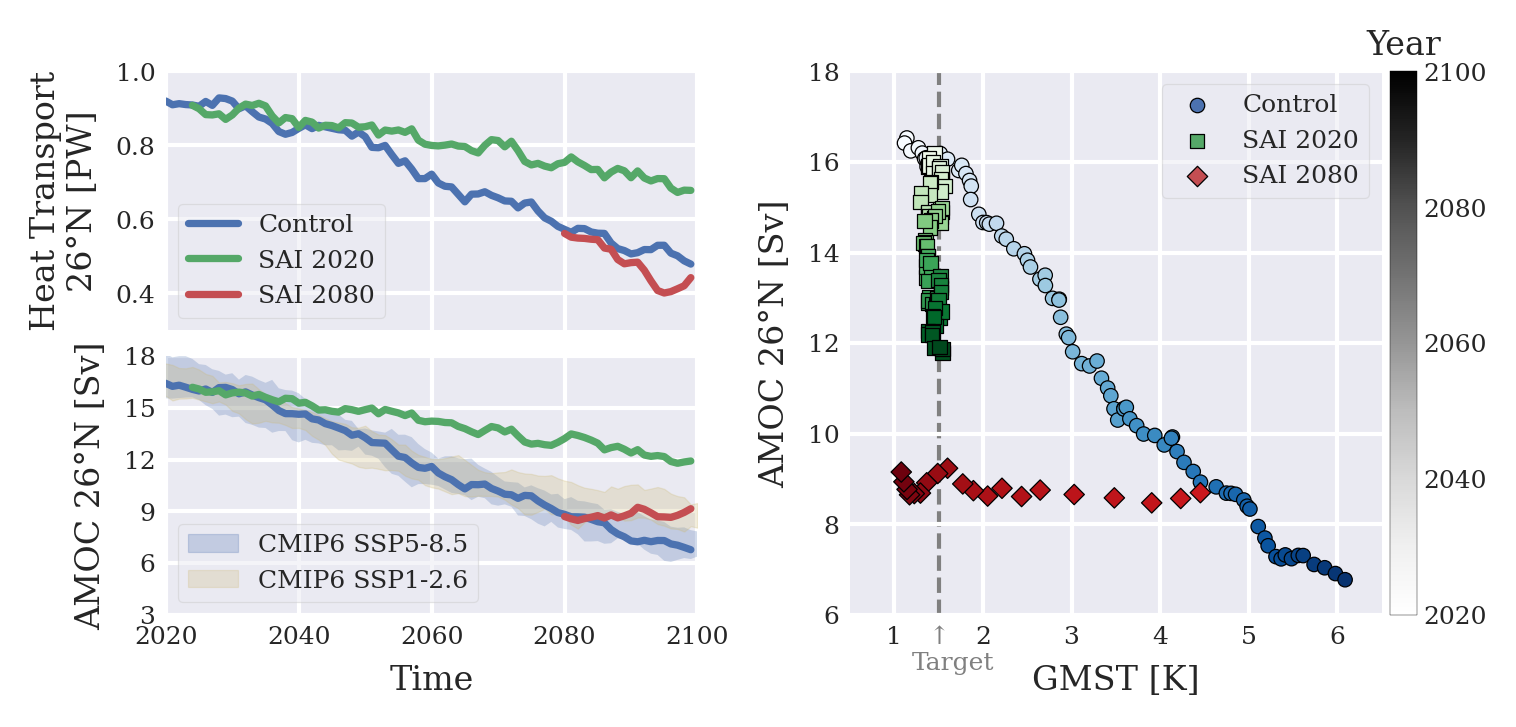

In [35]:
plt.rcParams["font.family"] = "serif"

T_ref = 288.73-1.5 # replace this with PI reference
T_target = T_ref+1.5 # replace!

widths = [1,1,0.05]
fig3, axes = plt.subplots(ncols=3, nrows=2, figsize=(6.0,2.4),dpi=300,
                        gridspec_kw={'width_ratios':widths,'hspace':0.1,'wspace':0.42})

gs = axes[0,0].get_gridspec()

# remove the underlying axes
for ax in axes[0,:]:
    ax.remove()
for ax in axes[1,:]:
    ax.remove()
    
ax_nwht = fig3.add_subplot(gs[0,0])
ax_amoc = fig3.add_subplot(gs[1,0]) 
ax_2d = fig3.add_subplot(gs[:,1])
ax_cb = fig3.add_subplot(gs[:,2])


#
# 1st plot
#
ax = ax_amoc

for name in scenarios_lim:
    mmax = moc_max(scenarios[name]['MOC'].groupby('time.year').mean(dim='time'),min_depth=min_depth,comps=[0,1,2],lat=lat)\
        .rolling(year=window).mean()
    if name == 'SAI 2080':
        mmax = mmax.sel(year=slice('2080','2100'))
    mmax.plot(ax=ax)

std = moc_max_cmip(amoc_cmip['ssp585'].groupby('time.year').mean(dim='time'),min_depth=min_depth,lat=lat)\
    .std(dim='ens').rolling(year=window).mean()
mean = moc_max_cmip(amoc_cmip['ssp585'].groupby('time.year').mean(dim='time'),min_depth=min_depth,lat=lat)\
    .mean(dim='ens').rolling(year=window).mean()

std2 = moc_max_cmip(amoc_cmip['ssp126'].groupby('time.year').mean(dim='time'),min_depth=min_depth,lat=lat)\
    .std(dim='ens').rolling(year=window).mean()
mean2 = moc_max_cmip(amoc_cmip['ssp126'].groupby('time.year').mean(dim='time'),min_depth=min_depth,lat=lat)\
    .mean(dim='ens').rolling(year=window).mean()

# where some data has already been plotted to ax
handles, labels = ax.get_legend_handles_labels()

# manually define a new patch 
patch = mpatches.Patch(color='C0', label='CMIP6 SSP5-8.5', alpha=0.25)
handles.append(patch)

# manually define a new patch 
patch2 = mpatches.Patch(color='C4', label='CMIP6 SSP1-2.6', alpha=0.25)
handles.append(patch2)

ax.fill_between(mean.year,mean-2*std,mean+2*std,alpha=0.25)
ax.fill_between(mean2.year,mean2-2*std2,mean2+2*std2,alpha=0.25,color='C4')

ax.legend(handles=handles,fontsize=fsize_min,frameon=True,framealpha=0.5,edgecolor=None)

ax.set_ylabel('AMOC 26°N [Sv]',fontsize=fsize)
ax.set_xlabel('Time',fontsize=fsize)
ax.set_xticks([2020,2040,2060,2080,2100])

ax.set_title('')
ax.set_xlim([2020,2100])
ax.set_ylim([3,18])
ax.set_yticks([3,6,9,12,15,18])
#plt.xlim([cftime.DatetimeNoLeap(2020,1,1),cftime.DatetimeNoLeap(2100,1,1)])

ax.set_xlim([2020,2100])

#
# 2nd plot
#
ax = ax_nwht

for name in scenarios_lim:
    result = mht(scenarios[name].var['N_HEAT'],lat=lat)\
        .groupby('time.year').mean(dim='time')\
        .rolling(year=window).mean()
    if name == 'SAI 2080':
        result = result.sel(year=slice('2080','2100'))
    result.plot(ax=ax,label=name)
ax.set_ylabel(f'Heat Transport\n26°N [PW]',fontsize=fsize)
ax.set_xticklabels([None])
ax.set_xlabel(None)
ax.set_xlim([2020,2100])
ax.set_ylim([0.3,1.0])
#ax.legend()
ax.set_title('')

ax.legend(fontsize=fsize_min,frameon=True,framealpha=0.5,edgecolor=None)

#
# 3rd plot
#
ax = ax_2d

# Create colormaps based on C0, C1, C2 to indicate years
# Use saturated versions of this colors as the 2100 color
year_norm = matplotlib.colors.Normalize(vmin=2020,vmax=2100)
cols_rgb = [
    matplotlib.colors.to_rgba(col) for col in ['C0','C1','C2']
]
cols_hsv = [
    matplotlib.colors.rgb_to_hsv(col[0:3]) for col in cols_rgb
]
# Saturate the colors
for col in cols_hsv:
    col[1] = 1
cols_sat = [
    matplotlib.colors.hsv_to_rgb(col) for col in cols_hsv
]
'''
cmaps_scatter = [
    matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",cols_sat[0]]),
    matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",cols_sat[1]]),
    matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",cols_sat[2]])]
'''

cmaps_scatter = [
    'Blues',
    'Greens',
    'Reds'
]

#ax.axvline(x=1.5,color='grey',linestyle='dashed',zorder=1)
ax.text(1.2,4.8,'Target',fontsize=fsize_min,color='grey')
markers = ['o','s','D']

for name, cmap_s, marker in zip(scenarios_lim,cmaps_scatter,markers):

    ai = moc_max(scenarios[name]['MOC'].groupby('time.year').mean(dim='time'),
                 min_depth=min_depth,comps=[0,1,2],lat=lat)\
        .rolling(year=window).mean()

    '''
    ai = mht(scenarios[name].var['N_HEAT'].groupby('time.year').mean(dim='time'),lat=lat)\
        .rolling(year=window).mean()
    '''
    gmst = scenarios[name]['TREFHT'].geo.sfc_mean()\
        .groupby('time.year').mean(dim='time')\
        .rolling(year=window).mean()
    if name == 'SAI 2080':
        gmst = gmst.sel(year=slice('2080','2100'))
        ai = ai.sel(year=slice('2080','2100'))
    ax.scatter(gmst.data-T_ref,ai.data,s=12,edgecolors='black',
              c=ai.year,cmap=cmap_s, norm=year_norm,zorder=2,marker=marker,label=name)

ax.set_xlim([0.5,6.5])
ax.set_xticks([1,1.5,2,3,4,5,6])
ax.set_xticklabels([1,'↑',2,3,4,5,6])
ax.get_xticklabels()[1].set_color('grey')
ax.get_xgridlines()[1].set_color('grey')
ax.get_xgridlines()[1].set_linestyle('dashed')
ax.set_ylim([6,18])
ax.set_ylabel('AMOC 26°N [Sv]',fontsize=fsize)
ax.set_xlabel('GMST [K]',fontsize=fsize)
ax.legend(fontsize=fsize_min,frameon=True,framealpha=0.5,edgecolor=None)
scatter_legend = ax.get_legend()
colors = ['C0','C1','C2']
for color, legendHandle in zip(colors,scatter_legend.legendHandles):
    legendHandle.set_color(color)
    legendHandle.set_edgecolor('black')
    
cb_2d = fig3.colorbar(matplotlib.cm.ScalarMappable(norm=year_norm, cmap=plt.get_cmap('Greys')),
             cax=ax_cb,drawedges=True)

#cb_2d.outline.set_visible(True)
cb_2d.outline.set_linewidth(0.1)
cb_2d.outline.set_edgecolor('black')
cb_2d.ax.set_yticks([2020,2040,2060,2080,2100])
#for yr in [2020,2040,2060,2080,2100]:
#    cb_2d.ax.axhline(y=yr,color='black',linewidth=0.1)
#cb_2d.ax.set_ylim([0,1])
cb_2d.ax.set_yticklabels(['2020','2040','2060','2080','2100'],fontsize=fsize_min,
                        rotation=0)
cb_2d.ax.set_title('Year',fontsize=fsize,pad=4.0)
cb_2d.ax.yaxis.set_tick_params(pad=1.5)
# rasterize colorbar for smooth pdf output
cb_2d.ax.set_rasterized(True)

dx = 0.08
pos = ax_cb.get_position()
pos.x0 -= dx    
pos.x1 -= dx
ax_cb.set_position(pos)

'''
ratio = 1.0
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
'''

for ax in [ax_amoc,ax_nwht,ax_2d]:
    ax.tick_params(axis='both',labelsize=fsize_min,pad=2.5)
    
    
###
fig3.tight_layout(pad=0.2)

In [36]:
fig3.savefig('./gfx/fig_3a.pdf',bbox_inches='tight')

# 3b AMOC Stream function

In [37]:
top_dir = '/home/dpfluger/scripts/make_moc_files/'

# Control
cnt_dir = os.path.join(top_dir,
                       'b.e21.BSSP585cmip6.f09_g17.control.01/msf/')
amoc_cnt = msf_tools.amoc_indices(cnt_dir)

# SAI 2020
sai20_dir_1 = os.path.join(top_dir,
                          'b.e21.BSSP585cmip6.f09_g17.2020feedback.01/msf/')
sai20_dir_2 = os.path.join(top_dir,
                          'b.e21.BSSP585cmip6.f09_g17.2020feedback.02/msf/')
sai20_1 = msf_tools.amoc_indices(sai20_dir_1)
sai20_2 = msf_tools.amoc_indices(sai20_dir_2)
amoc_sai20 = xr.concat([sai20_1,sai20_2],dim='time')
# SAI 2080
sai80_dir_1 = os.path.join(top_dir,
                          'b.e21.BSSP585cmip6.f09_g17.feedback.05/msf')
sai80_dir_2 = os.path.join(top_dir,
                          'b.e21.BSSP585cmip6.f09_g17.feedback.06/msf')
sai80_1 = msf_tools.amoc_indices(sai80_dir_1)
sai80_2 = msf_tools.amoc_indices(sai80_dir_2)
amoc_sai80 = xr.concat([sai80_1,sai80_2],dim='time')

# Wrap everything in a dictionary
amoc_mk = {}
amoc_mk['Control'] = amoc_cnt
amoc_mk['SAI 2020'] = amoc_sai20
amoc_mk['SAI 2080'] = amoc_sai80

amoc_mk['SAI 2080'] = xr.concat(
    [amoc_mk['Control'].sel(time=slice('2060','2079')),amoc_mk['SAI 2080']],
    dim='time')

In [38]:
def amoc_mk_diff(scenario_name,ts_i,ts_f,amoc_dict=amoc_mk):
    moc_f = amoc_dict[scenario_name].TMTA.sel(time=ts_f).mean(dim='time')
    moc_i = amoc_dict[scenario_name].TMTA.sel(time=ts_i).mean(dim='time')
    return moc_f-moc_i

ts_i = slice("2070","2079") 
ts_f = slice("2090","2099")
# 'general' reference period:
# this is only to get an idea what AMOC looks like in CESM 2
ts_gen_ref = slice('2020','2030') 

# Compute AMOC changes
stream_mk_minus_trend = {}
stream_mk_minus_trend['Control'] = amoc_mk_diff('Control',ts_i=ts_i,ts_f=ts_f,amoc_dict=amoc_mk)

for name in ['SAI 2020','SAI 2080']:
    diff = amoc_mk_diff(name,ts_i=ts_i,ts_f=ts_f)
    stream_mk_minus_trend[name] = (diff - stream_mk_minus_trend['Control'])

stream_mk_minus_trend['Diff'] = (stream_mk_minus_trend['SAI 2080'] - stream_mk_minus_trend['SAI 2020'])
# Compute reference AMOCs
stream_ref = {}
for name in ['Control', 'SAI 2020']:
    stream_ref[f'{name} Ref'] = amoc_mk[name].TMTA.sel(time=ts_i).mean(dim='time')
stream_ref['SAI 2080 Ref'] = stream_ref['Control Ref']
# General reference for streamfunction in CESM2 (current conditions)
stream_ref['General Ref'] = amoc_mk['Control'].TMTA.sel(time=ts_gen_ref).mean(dim='time')
    
# Create single result dictionary for easy reference
da_dict = stream_mk_minus_trend
for name in ['General','Control', 'SAI 2020','SAI 2080']:
    da_dict[f'{name} Ref'] = stream_ref[f'{name} Ref']
    
    
# limit data view
# necessary for contour plots
# labels might not show otherwise
for name in da_dict:
    da_dict[name] = da_dict[name].sel(lat=slice(-30,60))

In [39]:
from matplotlib.transforms import Affine2D, offset_copy

def rainbow_text(x, y, strings, colors, orientation='horizontal',
                 ax=None, **kwargs):
    """
    Take a list of *strings* and *colors* and place them next to each
    other, with text strings[i] being shown in colors[i].

    Parameters
    ----------
    x, y : float
        Text position in data coordinates.
    strings : list of str
        The strings to draw.
    colors : list of color
        The colors to use.
    orientation : {'horizontal', 'vertical'}
    ax : Axes, optional
        The Axes to draw into. If None, the current axes will be used.
    **kwargs
        All other keyword arguments are passed to plt.text(), so you can
        set the font size, family, etc.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    fig = ax.figure
    canvas = fig.canvas

    assert orientation in ['horizontal', 'vertical']
    if orientation == 'vertical':
        kwargs.update(rotation=90, verticalalignment='bottom')

    for s, c in zip(strings, colors):
        text = ax.text(x, y, s + " ", color=c, transform=t, **kwargs)

        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        # Convert window extent from pixels to inches
        # to avoid issues displaying at different dpi
        ex = fig.dpi_scale_trans.inverted().transform_bbox(ex)

        if orientation == 'horizontal':
            t = text.get_transform() + \
                offset_copy(Affine2D(), fig=fig, x=ex.width, y=0)
        else:
            t = text.get_transform() + \
                offset_copy(Affine2D(), fig=fig, x=0, y=ex.height)

In [40]:
%%capture 
# capture redirects cell output so that we dont get the empty matplotlib figure in jupyter

fsize = 8
fsize_min = 6

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(9*0.77,4.5*0.77),dpi=300,
                        gridspec_kw={'hspace':0.14,'wspace':0.012})
gs = axs[0,0].get_gridspec()

# remove the underlying axes
for ax in axs[0,:]:
    ax.remove() 
for ax in axs[1,:]:
    ax.remove() 
    
#
# AXES
#
ax_dict = {
    'General Ref':fig.add_subplot(gs[0, 0]),
    'Control':fig.add_subplot(gs[0, 1]),
    'SAI 2020':fig.add_subplot(gs[1, 0]),
    'SAI 2080':fig.add_subplot(gs[1, 1])
}

#
# PLOT PARAMS
#

lat, lev = da_dict['General Ref'].lat, da_dict['General Ref'].lev

levels_asym = [-4,-2,0,3,6,9,12,15]
levels_sym = np.linspace(-5,18,8,endpoint=True)
levels = 12

cont_alpha = 1
lwidths = 0.5
cont_params = {
    'Control': {'levels': levels_asym, 'linewidths': lwidths, 'colors': 'black', 'extend': 'both', 'alpha': cont_alpha},
    'SAI 2020': {'levels': levels_asym, 'linewidths': lwidths, 'colors': 'black', 'extend': 'both', 'alpha': cont_alpha},
    'SAI 2080': {'levels': levels_asym, 'linewidths': lwidths, 'colors': 'black', 'extend': 'both', 'alpha': cont_alpha},
}

#cmap_diff = colorcet.cm.gwv.reversed()
cmap_diff = 'PiYG'
#cmap_diff = 'PRGn'
#cmap_gen = 'viridis'
cmap_gen = colorcet.cm.gouldian

contf_params = {
    'General Ref': {'levels': np.linspace(-3,18,levels,endpoint=True), 'cmap': cmap_gen, 'extend': 'both'},
    'Control': {'levels': np.linspace(-4,4,levels,endpoint=True), 'cmap': cmap_diff, 'extend': 'both'},
    'SAI 2020': {'levels': np.linspace(-3,3,levels,endpoint=True), 'cmap': cmap_diff, 'extend': 'both'},
    'SAI 2080': {'levels': np.linspace(-3,3,levels,endpoint=True), 'cmap': cmap_diff, 'extend': 'both'},
}

cb_tick_params = {
    'General Ref': [-3,0,3,6,9,12,15,18,21],
    'Control': [-4,-3,-2,-1,0,1,2,3,4],
    'SAI 2020': [-3,-2,-1,0,1,2,3],
    'SAI 2080': [-3,-2,-1,0,1,2,3]
}

cbs = {}
contfs = {}
conts = {}
for name in ['General Ref','Control', 'SAI 2020', 'SAI 2080']:
    contfs[name] = ax_dict[name].contourf(lat,lev,da_dict[name],**contf_params[name],zorder=-2)
    if name != 'General Ref':
        conts[name] = ax_dict[name].contour(lat,lev,da_dict[f'{name} Ref'],**cont_params[name],zorder=-1)
        plt.clabel(conts[name],fmt='%d',fontsize=fsize_min)
    cbs[name] = plt.colorbar(contfs[name],ax=ax_dict[name],
                             shrink=1,pad=0.03,fraction=0.1,ticks=cb_tick_params[name])
    
    
for name in ['General Ref','Control', 'SAI 2020', 'SAI 2080']:
    ax_dict[name].set_ylim([0,5000*100])
    ax_dict[name].invert_yaxis()
    ax_dict[name].tick_params(labelsize=fsize_min,pad=2.5)
    ax_dict[name].set_yticklabels([0,1,2,3,4,5])
    ax_dict[name].grid(zorder=0,linestyle='dashed',linewidth=0.5,alpha=0.5,b=True)
    cbs[name].ax.tick_params(labelsize=fsize_min,pad=2.5)

# y label
ax_dict['General Ref'].set_ylabel('Depth [km]',fontsize=fsize)
ax_dict['SAI 2020'].set_ylabel('Depth [km]',fontsize=fsize)
ax_dict['Control'].set_yticklabels([None])
ax_dict['SAI 2080'].set_yticklabels([None])

# x label
ax_dict['SAI 2020'].set_xlabel('Latitude [°N]',fontsize=fsize)
ax_dict['SAI 2080'].set_xlabel('Latitude [°N]',fontsize=fsize)
ax_dict['General Ref'].set_xticklabels([None])
ax_dict['Control'].set_xticklabels([None])

# cb label
cbs['General Ref'].ax.set_title('[Sv]',fontsize=fsize_min,pad=2.5)
cbs['Control'].ax.set_title('[Sv]',fontsize=fsize_min,pad=2.5)

# titles
dy_title = -150*100
rainbow_text(-6,dy_title,['Control', 'AMOC' ' (2020-2030)'],
             colors = ['C0', 'black','black'],
             ax=ax_dict['General Ref'],fontsize=fsize)

rainbow_text(7,dy_title,[r'$\Delta\,$Control'],
             colors = ['C0'],
             ax=ax_dict['Control'],fontsize=fsize)

rainbow_text(-3,dy_title,[r'$\Delta\,$SAI 2020 ','-','$\Delta\,$Control'],
             colors = ['C1','black','C0'],
             ax=ax_dict['SAI 2020'],fontsize=fsize)

rainbow_text(-3,dy_title,[r'$\Delta\,$SAI 2080 ','-','$\Delta\,$Control'],
             colors = ['C2','black','C0'],
             ax=ax_dict['SAI 2080'],fontsize=fsize)


# legends

from matplotlib.lines import Line2D
legend_line = [Line2D([0], [0], color='black', lw=lwidths)]
ax_dict['Control'].legend(legend_line, ['Control AMOC (2070-2080)'], fontsize=fsize_min,
                        frameon=True,framealpha=0.8,edgecolor=None,loc='lower right')
ax_dict['SAI 2020'].legend(legend_line, ['SAI 2020 AMOC (2070-2080)'], fontsize=fsize_min,
                        frameon=True,framealpha=0.8,edgecolor=None,loc='lower right')
ax_dict['SAI 2080'].legend(legend_line, ['SAI 2080 AMOC (2070-2080)'], fontsize=fsize_min,
                        frameon=True,framealpha=0.8,edgecolor=None,loc='lower right')


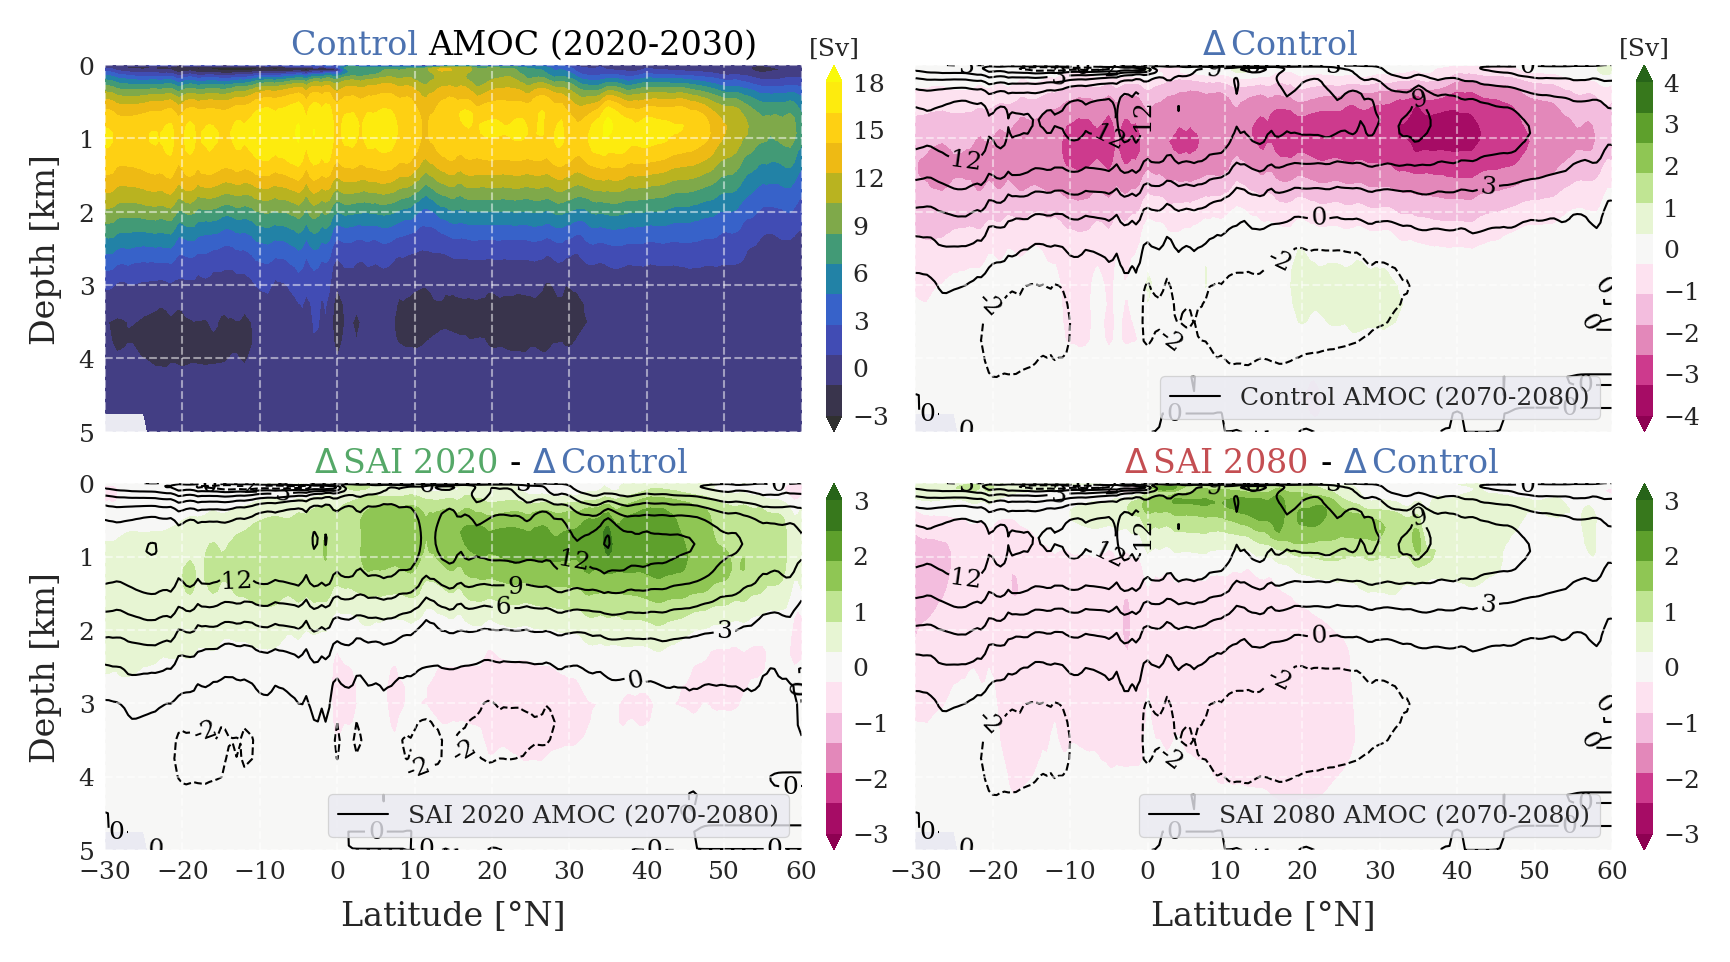

In [41]:
fig

In [42]:
fig.savefig('./gfx/fig_3b.pdf',bbox_inches='tight')

# 4 Deep water formation in North Atlantic

Mixed layer volume plot in east and west, selected ROI in ref

## Computation

In [43]:
month_strats = {}
month_i = 9
z_test = 200

month_strats = {}

for name in scenarios:
    da = xr.open_dataset(f'./data/strat_total_{name}.nc')
    da = da[list(da.data_vars.keys())[0]]
    month_strats[name] = da
    
mlm = {
    name: dwf_mean(month_ml_depth(scenarios[name]),mask_roi=tarea_dwf).compute()\
        for name in scenarios 
}
mlm_east = {
    name: dwf_mean(month_ml_depth(scenarios[name]),mask_roi=tarea_dwf_east).compute()\
        for name in scenarios     
}
mlm_west = {
    name: dwf_mean(month_ml_depth(scenarios[name]),mask_roi=tarea_dwf_west).compute()\
        for name in scenarios 
}

mx_month_c = (pop_plot.add_cyclic_coords(mx_month.to_dataset())).HMXL/100
dwf_east_c = (pop_plot.add_cyclic_coords(dwf_east.to_dataset())).HMXL/100
dwf_west_c = (pop_plot.add_cyclic_coords(dwf_west.to_dataset())).HMXL/100

sst, sst_east, sst_west = {}, {}, {}
sss, sss_east, sss_west = {}, {}, {}
rho_sfc, rho_sfc_east, rho_sfc_west = {}, {}, {}

for var_name, var_dict in zip(['sst','sst_east','sst_west'],[sst,sst_east,sst_west]):
    for name in scenarios:
        da = xr.open_dataset(f'./data/{var_name}_{name}.nc')
        da = da[list(da.data_vars.keys())[0]]
        var_dict[name] = da
        
for var_name, var_dict in zip(['sss','sss_east','sss_west'],[sss,sss_east,sss_west]):
    for name in scenarios:
        da = xr.open_dataset(f'./data/{var_name}_{name}.nc')
        da = da[list(da.data_vars.keys())[0]]
        var_dict[name] = da
        
for var_name, var_dict in zip(['rho_sfc','rho_sfc_east','rho_sfc_west'],[rho_sfc,rho_sfc_east,rho_sfc_west]):
    for name in scenarios:
        da = xr.open_dataset(f'../../ocean_convection/data/{var_name}_{name}.nc')
        da = da[list(da.data_vars.keys())[0]]
        var_dict[name] = da

## Plot

In [44]:
fsize = 8
fsize_min = 6

fontf = {'family': 'Nimbus Roman',
        'fontsize': 8
        }

# #eaeaf2 seaborn face color

Text(329, 55, '† ~2070')

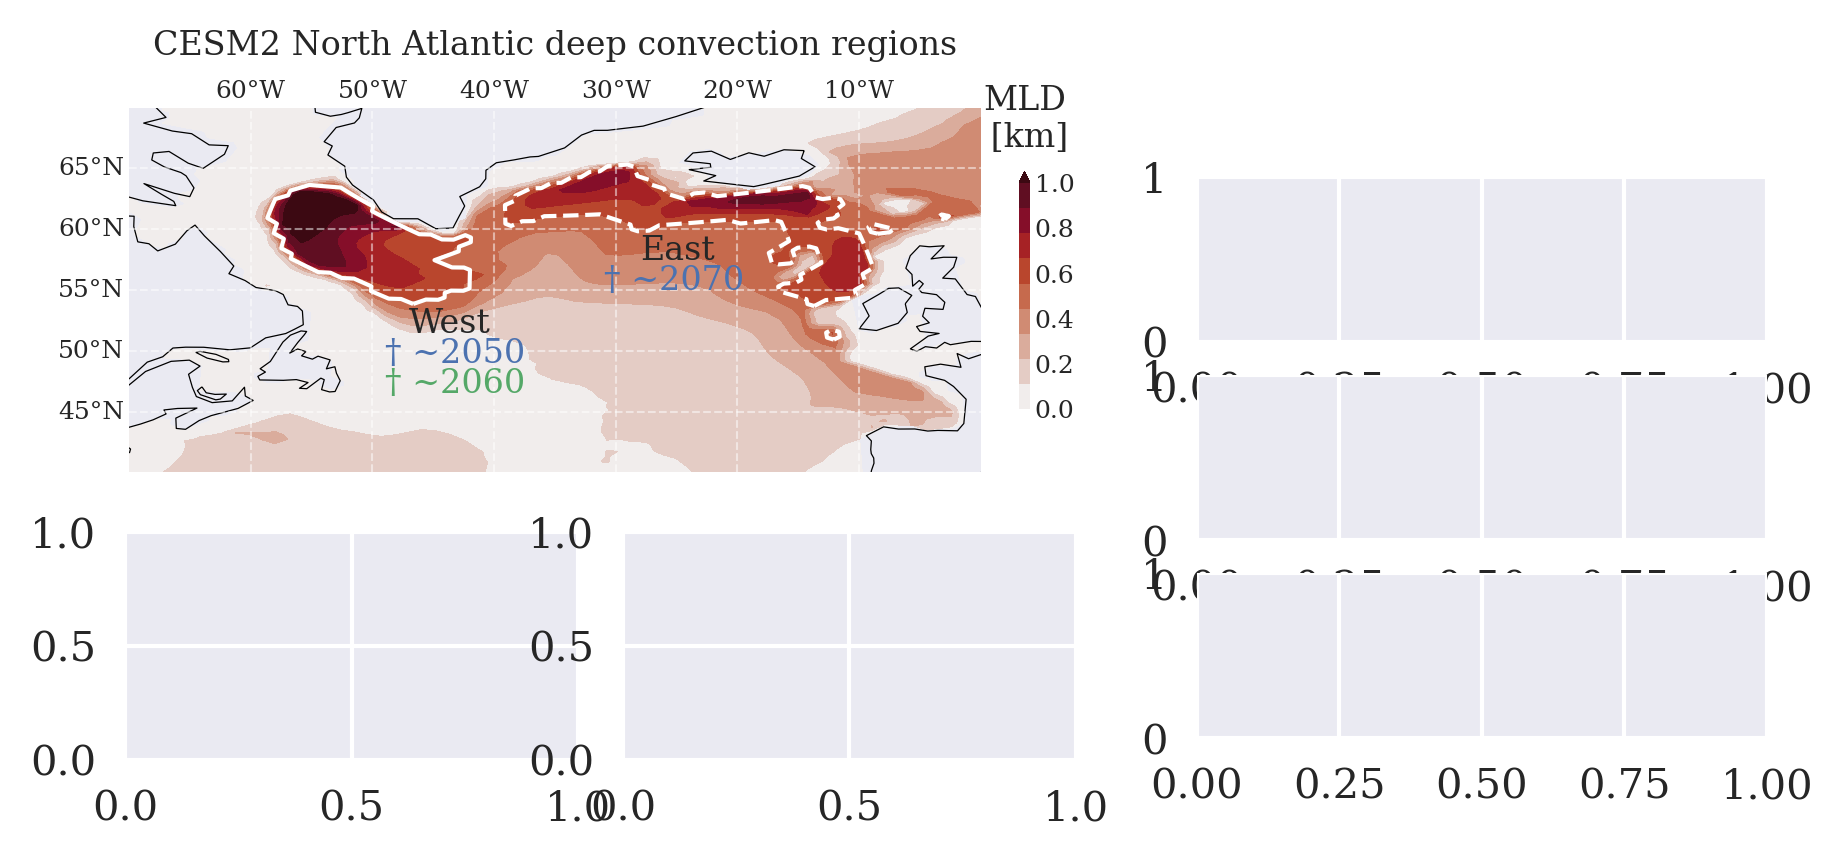

In [45]:
# -*- coding: utf-8 -*-
fig4 = plt.figure(dpi=300,figsize=(7.2*0.8,3.6*0.8))

gs1 = GridSpec(nrows=2, ncols=2, height_ratios=[1.6,1])
gs1.update(left=0.05, right=0.6, hspace=0.2, wspace=0.10)
ax1_1 = plt.subplot(gs1[0:1, :],projection=ccrs.PlateCarree())
ax1_2 = plt.subplot(gs1[1, 0])
ax1_3 = plt.subplot(gs1[1, 1])

gs2 = GridSpec(3, 1)
gs2.update(left=0.67, right=1, hspace=0.20,top=0.80,bottom=0.15)

ax_strat = plt.subplot(gs2[0,0])
ax_sst = plt.subplot(gs2[1,0])
ax_sss = plt.subplot(gs2[2,0])

# Map

mx_month_c.plot.contourf(x='TLONG',y='TLAT',transform=ccrs.PlateCarree(),ax=ax1_1,cmap=cmocean.cm.amp,
                            levels=np.linspace(0,1000,10),
                            cbar_kwargs={'orientation': 'vertical', 'shrink': 0.65, 'pad': 0.04, 'fraction': 0.06,
                            'ticks': [0,200,400,600,800,1000], 'label': None, 'extend': 'max'})

dwf_east.plot.contour(x='TLONG',y='TLAT',transform=ccrs.PlateCarree(),ax=ax1_1,
                      levels=1,colors='white',linewidths=1,linestyles='dashed')
dwf_west.plot.contour(x='TLONG',y='TLAT',transform=ccrs.PlateCarree(),ax=ax1_1,
                      levels=1,colors='white',linewidths=1,linestyles='solid')

ax1_1.set_extent([-70, 0, 40, 70], crs=ccrs.PlateCarree())
ax1_1.coastlines('110m')
ax1_1.set_title('CESM2 North Atlantic deep convection regions',fontsize=fsize)

#ax1_1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
#                color='grey',alpha=0.25,linestyle='dashed')
gl = ax1_1.gridlines(draw_labels=True,linestyle='dashed',alpha=0.5,linewidth=0.5)
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlabel_style = {'fontsize': fsize_min}
gl.ylabel_style = {'fontsize': fsize_min}

cb = fig4.axes[-1]
cb.set_yticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
cb.set_title('MLD\n [km]',fontsize=fsize)
cb.tick_params(labelsize=fsize_min,pad=1.1)

ax1_1.text(313, 51.5, 'West',
         transform=ccrs.PlateCarree(),fontsize=fsize)
ax1_1.text(311, 49, u'† ~2050',
         transform=ccrs.PlateCarree(),fontsize=fsize,color='C0')
ax1_1.text(311, 46.6, u'† ~2060',
         transform=ccrs.PlateCarree(),fontsize=fsize,color='C1')

ax1_1.text(332, 57.5, 'East',
         transform=ccrs.PlateCarree(),fontsize=fsize)
ax1_1.text(329, 55, u'† ~2070',
         transform=ccrs.PlateCarree(),fontsize=fsize,color='C0')

In [46]:
ax1_2.clear()
ax1_3.clear()

colors = ['C0','C1','C2']

for name, color in zip(scenarios, colors):
    ts = slice('2020','2100')
    if name in ['SAI 2080','SAI 2080 J']:
        ts = slice('2080','2100')
    mlm_west[name].sel(time=ts).plot(ax=ax1_2,alpha=0.25,color=color)
    mlm_east[name].sel(time=ts).plot(ax=ax1_3,alpha=0.25,color=color)
    mlm_west[name].rolling(time=5).mean().sel(time=ts).plot(label=name,ax=ax1_2,color=color)
    mlm_east[name].rolling(time=5).mean().sel(time=ts).plot(ax=ax1_3,color=color)

ttick_i, ttick_f = cftime.DatetimeNoLeap(2020,1,1), cftime.DatetimeNoLeap(2100,1,1)

for ax_sel in [ax1_2,ax1_3]:
    ax_sel.set_title(None)
    ax_sel.tick_params(axis='both', which='major', labelsize=fsize_min, pad=2)
    ax_sel.tick_params(axis='x', which='major', rotation=45)
    ax_sel.set_xlim([ttick_i,ttick_f])
    ax_sel.set_ylim([0,1200*100])

ax1_2.legend(fontsize=fsize_min,
                        frameon=True,framealpha=0.5,edgecolor=None)
ax1_3.set_yticks([0,200*100,400*100,600*100,800*100,1000*100,1200*100])
ax1_3.set_yticklabels([None for i in range(0,7)])
ax1_2.set_yticks([0,200*100,400*100,600*100,800*100,1000*100,1200*100])
ax1_2.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0','1.2'])

ax1_2.set_ylabel('April MLD [km]',fontsize=fsize)

ax1_2.set_xlabel('Time',fontdict=fontf)
ax1_3.set_xlabel('Time',fontdict=fontf)

ax1_2.set_title('West',fontsize=fsize,pad=2)
ax1_3.set_title('East',fontsize=fsize,pad=2)

Text(0.5, 1.0, 'East')

In [47]:
for ax in [ax_strat,ax_sst,ax_sss]:
    ax.clear()
for name in ['Control', 'SAI 2020', 'SAI 2080']:
    ts = slice('2020','2100')
    if name == 'SAI 2080':
        ts = slice('2080','2100')
    #sst_mean = sst[name].groupby('time.year').mean(dim='time')
    #sss_mean = sss[name].groupby('time.year').mean(dim='time')
    # select september rather than annual mean:
    sst_mean = sst[name].groupby('time.month')[9] \
        .groupby('time.year').mean(dim='time') # hack to convert into integer time dimension
    sss_mean = sss[name].groupby('time.month')[9] \
        .groupby('time.year').mean(dim='time')
    sst_mean.sel(year=ts).plot(ax=ax_sst)
    sss_mean.sel(year=ts).plot(ax=ax_sss)
    
    # Apply unit conversion to stratification indicator:
    # kg/m^3 = 1000 g/m^3
    # groupby over years is technically redundant 
    # but gives the same 'year' time axis used by sst_mean & sss_mean
    # Plot upper density rather than stratification
    rho_sfc_mnth = rho_sfc[name].groupby('time.year').mean(dim='time') # hack to convert to int time dim
    ((rho_sfc_mnth-1)*1000).plot(ax=ax_strat)
    # unit: mg/cm^3, offset: 1000 mg/cm^3 = 1 g/cm^3
    
for ax_sel in [ax_strat,ax_sst,ax_sss]:
    ax_sel.set_title(None)
    ax_sel.tick_params(axis='both', which='major', labelsize=fsize_min, pad=2.0)
    ax_sel.set_xlim([2020,2100])
    ax_sel.set_xticks([2020,2040,2060,2080,2100])

'''
ax2_1.set_title(None)
ax2_2.set_title(None)
ax2_1.tick_params(axis='both', which='major', labelsize=8)
ax2_2.tick_params(axis='both', which='major', labelsize=8)
ax2_1.set_xlim([2020,2100])
ax2_2.set_xlim([2020,2100])

ax2_
'''

# SST styling
ax_sst.set_yticks([0,2,4,6,8,10,12])
ax_sst.set_ylim([4,14])
ax_sst.tick_params(axis='y')
ax_sst.set_xlabel(None)
ax_sst.set_ylabel('SST [°C]',fontdict=fontf)
ax_sst.set_xticklabels([])

# SSS styling
ax_sss.set_yticks([32,33,34,35,36])
ax_sss.set_ylim([31.5,35.5])
ax_sss.set_ylabel(r'SSS [$\mathregular{g/kg}$]',fontdict=fontf)
#ax_sss.tick_params(axis='x',rotation=45)
ax_sss.set_xlabel('Time',fontsize=fsize_min)
ax_sss.tick_params(axis='x',rotation=45)

# Strat styling 
ax_strat.set_ylabel(r'Density [$\mathregular{mg/cm^3}$]',fontdict=fontf)
ax_strat.set_ylim([23.5,27.5])
ax_strat.set_yticks([23,24,25,26,27])
ax_strat.set_xlabel(None)
ax_strat.set_xticklabels([])

# Align y labels
fig4.align_ylabels([ax_strat,ax_sst,ax_sss])

# title of right column
#ax2_title = f.add_subplot(gs2)
#ax2_title.axis('off')
#ax2_title.set_title('Surface and stratification over combined region')

ax_strat.set_title('September sea surface in both regions',fontsize=fsize)

Text(0.5, 1.0, 'September sea surface in both regions')

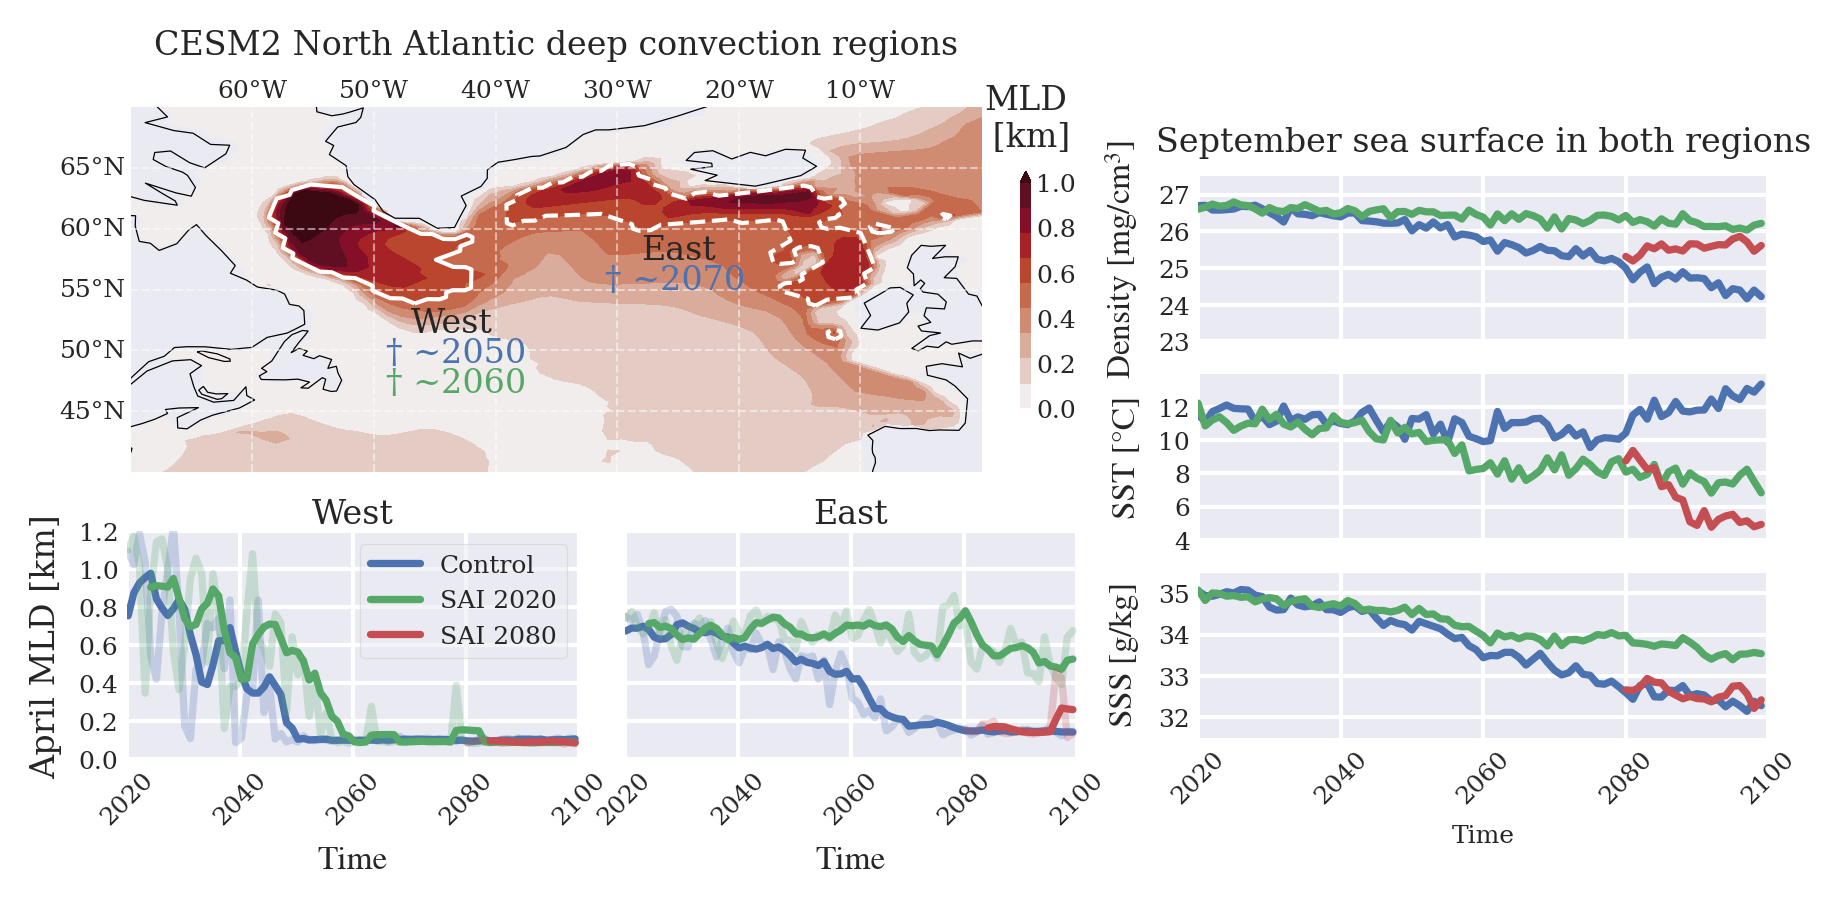

In [48]:
fig4

In [49]:
fig4.savefig('./gfx/fig_4.pdf',bbox_inches='tight')

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
